In [1]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt

In [3]:
cv2.__version__

'4.1.0'

In [3]:
MIN_MATCH_COUNT = 10

img1 = cv2.imread('datasets/l.jpg.', 0) # queryImage
img2 = cv2.imread('datasets/r.jpg', 0) # trainImage

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

good = []
keypoints1 = []
keypoints2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.12*n.distance:
        matchesMask[i]=[1,0]
        good.append(m)

for match in good:
    idx1 = match.trainIdx
    idx2 = match.queryIdx
    keypoints1.append( kp1[idx1].pt )
    keypoints2.append( kp2[idx2].pt )
    
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize = (20,2))
plt.imshow(img3,),plt.show()

error: OpenCV(4.1.0) /home/moizsajid/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1123: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


In [46]:
keypoints1_np.shape

(35, 2)

In [45]:
keypoints1_np = np.array(keypoints1)
keypoints2_np = np.array(keypoints2)

In [49]:
fundmat = cv2.findFundamentalMat(keypoints1_np, keypoints2_np)
projmat = cv2.findHomography(keypoints1_np, keypoints2_np)

In [55]:
basfundmat

(array([[-6.01174109e-06,  1.24566094e-05,  8.17590716e-02],
        [-1.14434126e-06,  2.92267552e-07,  4.05527304e-03],
        [-6.42016067e-02, -2.45228002e-02,  1.00000000e+00]]), array([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1]], dtype=uint8))

In [70]:
baseline = 193.001

Q = np.array([  [1, 0, 0, -1244.772],
                [0, 1, 0, -1019.507],
                [0, 0, 0, 3979.911],
                [0, 0, -1/baseline, (1244.772-1369.115)/baseline] ])

In [71]:
points = cv2.reprojectImageTo3D(disparity, Q)

In [72]:
f = open('python.off', 'w')

f.write("OFF\n")
f.write(str(points.shape[0] * points.shape[1]) + " 0 0\n")

for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        point = points[i][j]
        f.write(str(point[0]) + " " + str(point[1]) + " " + str(point[2]) + "\n")
        
f.close()

In [43]:
f = open('python.off', 'w')

f.write("COFF\n")
#f.write(str(np.sum(np.absolute(count_points[:, 2]))) + " 0 0\n")
f.write(str(len(points)) + " 0 0\n")

for point in points:
    #if np.absolute(point[2][0]) < 10:
#     f.write(str(point[0][0]) + " " + str(point[1][0]) + " " + str(point[2][0]) + "\n")
    f.write(str(point[0]) + " " + str(point[1]) + " " + str(point[2]) + "\n")
    
    
f.close()

In [ ]:
matched_points1 = []
matched_points2 = []

for (int i=0;i<;i++)
{
     int idx1=good_matches[i].trainIdx;
     int idx2=good_matches[i].queryIdx;
     matched_points1.push_back(keypoints1[idx1].pt);
     matched_points2.push_back(keypoints2[idx2].pt);
}

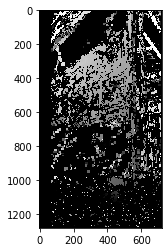

In [7]:
#imgL = cv2.imread('data/tsukuba_l.png',0)
#imgR = cv2.imread('data/tsukuba_r.png',0)


imgL_color = cv2.imread('datasets/l_1.jpg')
imgR_color = cv2.imread('datasets/r_1.jpg')

imgL = cv2.cvtColor(imgL_color, cv2.COLOR_RGB2GRAY);
imgR = cv2.cvtColor(imgR_color, cv2.COLOR_RGB2GRAY);

#imgL = cv2.resize(imgL, None, fx=0.1, fy=0.1)
#imgR = cv2.resize(imgR, None, fx=0.1, fy=0.1)


#stereo = cv2.StereoBM_create(numDisparities=32, blockSize=15)
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
disparity = stereo.compute(imgL,imgR)

disparity = np.float32(disparity)
disparity = disparity * 1.0 / 16.0


plt.imshow(disparity,'gray')
plt.show()

In [42]:
disparity[disparity <= 0] = 0

In [36]:
print(disparity.max())  # 4080
print(disparity.min())  # -16

255.0
-1.0


In [7]:
imgL.shape

(200, 296)

In [37]:
focal_length = 3979.911 
baseline = 193.001
#baseline = 0.193001


intrinsics = np.array([[3979.911, 0.0, 1244.772],
              [0.0, 3979.911, 1019.507],
              [0.0, 0.0, 1.0]])

intrinsics_inverse = np.linalg.inv(intrinsics)

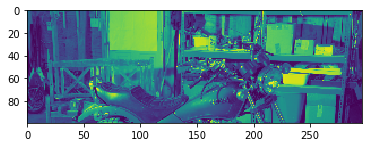

In [44]:
plt.imshow(imgL[:100, :])

In [54]:
points = []

Q03 = -1244.772
Q13 = -1019.507
Q23 = focal_length
Q32 = -1.0 / baseline
Q33 = (1244.772 - 1369.115) / baseline

for i in range(disparity.shape[0]):
    for j in range(disparity.shape[1]):
        if disparity[i, j] > 0:
            #2964.0 *
            #z = focal_length * baseline / (disparity[i, j])
            #x = float(j) * z / focal_length
            #y = float(i) * z / focal_length
            pw = 1.0 / (disparity[i, j] * Q32 + Q33)
            z = Q23 * pw
            x = (float(j) + Q03) * pw
            y = (float(i) + Q13) * pw
            (color_b, color_g, color_r) = imgL_color[i, j]
            
            #point = z * np.dot(intrinsics_inverse, np.array([[j], [i], [1]]))
    #             point =np.dot(z * intrinsics_inverse, np.array([[j], [i], [1]]))
            #point = np.dot(intrinsics_inverse, np.array([x, y, z]))
            point = np.array([x, y, z, color_r, color_g, color_b])
            points.append(point)

In [57]:
faces = []
edgeThreshold = 10

for idx in range(len(points)-2):
    
    pt1 = points[idx]
    pt2 = points[idx+1]
    pt3 = points[idx+2]
    
    len1 = np.linalg.norm(pt1-pt2)
    len2 = np.linalg.norm(pt1-pt3)
    len3 = np.linalg.norm(pt2-pt3)
    
    if(len1 + len2 + len3) <= edgeThreshold:
        faces.append(np.array([idx, idx+1, idx+2]))

In [81]:
len(points)

5927673

In [61]:
count_points.shape

(5927673, 3, 1)

In [58]:
count_points = np.array(points)

f = open('python.off', 'w')

f.write("COFF\n")
#f.write(str(np.sum(np.absolute(count_points[:, 2]))) + " 0 0\n")
f.write(str(len(points)) + " 0 0\n")

for point in points:
    #if np.absolute(point[2][0]) < 10:
    #f.write(str(point[0]) + " " + str(point[1]) + " " + str(point[2]) + "\n")
    f.write(str(point[0]) + " " + str(point[1]) + " " + str(point[2]) + " " + str(int(point[3])) + " " + str(int(point[4])) +" " + str(int(point[5])) + " 255 \n")

for face in faces:
    f.write(str(face[0]) + " " + str(face[1]) + " " + str(face[2]) + "\n")
    
f.close()

In [8]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('/home/moizsajid/opencv/samples/data/left*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

NameError: name 'corners2' is not defined

In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('datasets/Motorcycle-perfect/im0.png',0)  #queryimage # left image
img2 = cv2.imread('datasets/Motorcycle-perfect/im1.png',0) #trainimage # right image

#img1 = cv2.imread('datasets/ours/left_1.jpg',0)
#img2 = cv2.imread('datasets/ours/right_1.jpg',0)

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.2*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [35]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [36]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

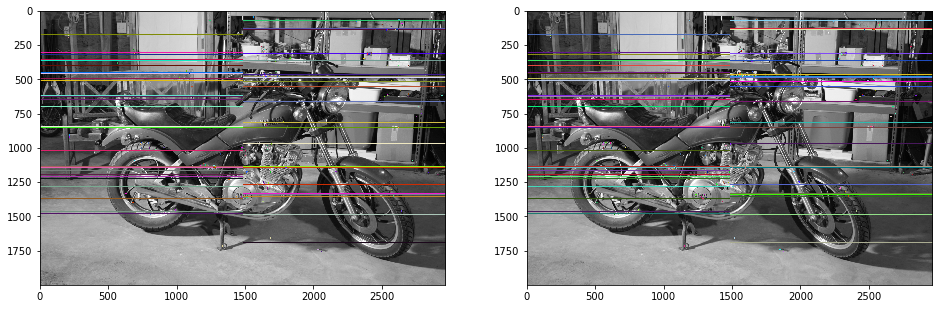

In [37]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(16, 12))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()